In [1]:
import numpy as np
import pymongo
#from sklearn import neural_network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import sys
import math
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Load data

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client["flowdb"]

In [3]:
#my data resulted in more data points under testP_agg so I used 
#that as the training collection instead of trainP_agg
p_train_coll = mydb["aggp2"]
p_test_coll = mydb["testP_agg"]
b_train_coll = mydb["aggb2"]
b_test_coll = mydb["testB_agg"]

n_test_coll = mydb["netflowagg"]

p_train = []
p_test = []
b_train = []
b_test = []
p_train_l = []
p_test_l = []
b_train_l = []
b_test_l = []
n_test = []

b_byte_dist_h = [0] * 256
b_ift_h = [0] * 15
p_byte_dist_h = [0] * 256
p_ift_h = [0] * 15
b_fl = np.zeros((10,10))
p_fl = np.zeros((10,10))

In [4]:
def getMD(doc, flag):
    tmp = []
    if doc['sp'][0] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['sp'][0])
        
    if doc['dp'][0] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['dp'][0])
    #tmp.append(doc['sp'][0])
    #tmp.append(doc['dp'][0])
    if doc['Source ASN'] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['Source ASN'])
    if doc['Dest ASN'] == None:
        tmp.append(-1)
    else:
        tmp.append(doc['Dest ASN'])
    tmp.append(doc['bytes_in'])
    tmp.append(doc['bytes_out'])
    tmp.append(doc['total_bytes'])
    tmp.append(doc['num_pkts_in'])
    tmp.append(doc['num_pkts_out'])
    tmp.append(doc['total_num_pkts'])
    tmp.append(doc['# of flows'])
    '''for i in range(256):
        if (doc['byte_dist'][i] != None):
            try:
                tmp.append(doc['byte_dist'][i])
                if (flag == 0):
                    b_byte_dist_h[i] += doc['byte_dist'][i]
                else:
                    p_byte_dist_h[i] += doc['byte_dist'][i] 
            except:
                tmp.append(0)
        else:
            tmp.append(0)'''
    return tmp

In [5]:
def getBD(doc, flag):
    for i in range(256):
        if (doc['byte_dist'][i] != None):
            try:
                tmp.append(doc['byte_dist'][i])
                if (flag == 0):
                    b_byte_dist_h[i] += doc['byte_dist'][i]
                else:
                    p_byte_dist_h[i] += doc['byte_dist'][i] 
            except:
                tmp.append(0)
        else:
            tmp.append(0)
    return tmp

In [6]:
def getIFTBuckets(doc, flag):
    tmp = []
    ifts = doc['ift']
    length = len(ifts)
    tmp.append(length)
    #tmp.append(np.mean(ifts))
    num = 15
    buckets = [0] * num
    sum = 0
    avg_ift = 0
    for ift in ifts:
        if ift > 0:
           logift = math.log(ift, 2)
        if ift == 0:
            buckets[0] += 1
            if(flag == 0):
                b_ift_h[0]+= 1
            else:
                p_ift_h[0] += 1
        elif logift <= 0:
            buckets[0] += 1
            if(flag == 0):
                b_ift_h[0]+= 1
            else:
                p_ift_h[0] += 1
            sum += ift
        elif logift >= 14:
            buckets[14] += 1
            if(flag == 0):
                b_ift_h[14]+= 1
            else:
                p_ift_h[14] += 1
            sum += ift
        else:
            buckets[int(math.floor(logift))] += 1
            if(flag == 0):
                b_ift_h[int(math.floor(logift))]+= 1
            else:
                p_ift_h[int(math.floor(logift))] += 1
            sum += ift
    
    if length > 1:
        avg_ift = sum / length
    tmp.append(avg_ift)
    tmp.extend(buckets)
    return tmp

In [7]:
def getIndividualFL(doc, flag):
    numRows = 10
    binSize = 200
    transMat = np.zeros((numRows, numRows))
    if len(doc['byte_array']) == 0:
        return list(transMat.flatten())
    elif len(doc['byte_array']) == 1:
        curFlowSize = min(int(doc['byte_array'][0] / binSize), numRows - 1)
        transMat[curFlowSize, curFlowSize] = 1
        return list(transMat.flatten())

    for i in range(1, len(doc['byte_array'])):
        prevFlowSize = min(int(doc['byte_array'][i-1] / binSize), numRows - 1)
        curFlowSize = min(int(doc['byte_array'][i] / binSize), numRows - 1)
        transMat[prevFlowSize, curFlowSize] += 1

    for i in range(numRows):
        if float(np.sum(transMat[i:i+1])) != 0:
            transMat[i:i+1] = transMat[i:i+1] / float(np.sum(transMat[i:i + 1]))
    for i in range(numRows):
        for j in range(numRows):
            if(flag == 0):
                b_fl[i][j] += transMat[i][j]
            elif(flag == 1):
                p_fl[i][j] += transMat[i][j]
    return list(transMat.flatten())

### set up training and testing data arrays

In [8]:
for doc in p_train_coll.find():
    tmpd = []
    tmp = getMD(doc, 1)
    tmpb = getBD(doc, 1)
    tmpbd = preprocessing.scale(tmpb)
    tmpift = getIFTBuckets(doc, 1)
    tmpind_fl = getIndividualFL(doc, 1)
    
    
    tmpd.extend(tmp)
    #tmpd.extend(tmpbd)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    p_train.append(tmpd)
    p_train_l.append(1)


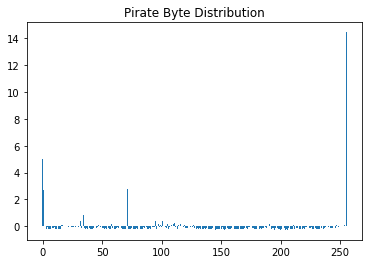

In [9]:
y_pos = np.arange(len(p_byte_dist_h))
x = preprocessing.scale(p_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Pirate Byte Distribution")
plt.show()

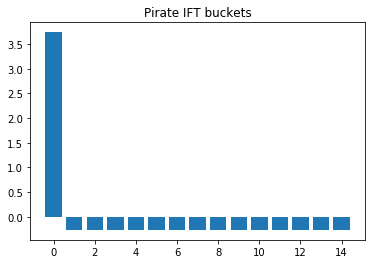

In [10]:
y_pos = np.arange(len(p_ift_h))
x = preprocessing.scale(p_ift_h)
plt.bar(y_pos, x)
plt.title("Pirate IFT buckets")
plt.show()

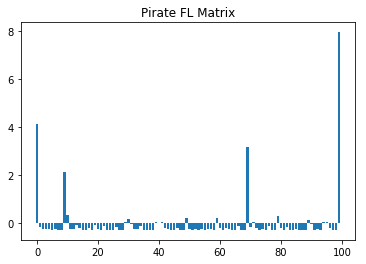

In [11]:
p_fl = p_fl.flatten()
y_pos = np.arange(len(p_fl))
x = preprocessing.scale(p_fl)
plt.bar(y_pos, x)
plt.title('Pirate FL Matrix')
plt.show()

In [12]:
for doc in p_test_coll.find():
    tmpd = []
    tmp = getMD(doc, 1)
    tmpb = getBD(doc, 1)
    tmpbd = preprocessing.scale(tmpb)
    tmpift = getIFTBuckets(doc, 1)
    tmpind_fl = getIndividualFL(doc, -1)
    
    
    tmpd.extend(tmp)
    #tmpd.extend(tmpbd)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    p_test.append(tmpd)
    p_test_l.append(1)
    

In [13]:
for doc in b_train_coll.find():
    tmpd = []
    tmp = getMD(doc, 0)
    tmpb = getBD(doc, 0)
    tmpbd = preprocessing.scale(tmpb)
    tmpift = getIFTBuckets(doc, 0)
    tmpind_fl = getIndividualFL(doc, 0)
    
    
    tmpd.extend(tmp)
    #tmpd.extend(tmpbd)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    b_train.append(tmpd)
    b_train_l.append(0)


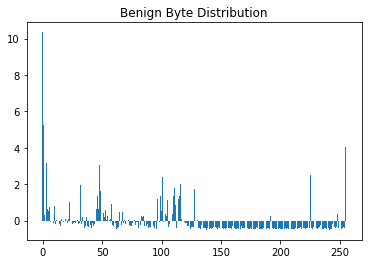

In [14]:
y_pos = np.arange(len(b_byte_dist_h))
x = preprocessing.scale(b_byte_dist_h)
plt.bar(y_pos, x)
plt.title("Benign Byte Distribution")
plt.show()

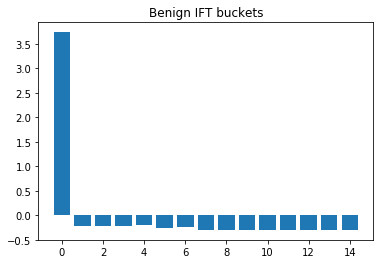

In [15]:
y_pos = np.arange(len(b_ift_h))
x = preprocessing.scale(b_ift_h)
plt.bar(y_pos, x)
plt.title("Benign IFT buckets")
plt.show()

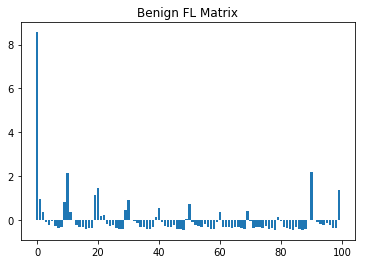

In [16]:
b_fl = b_fl.flatten()
y_pos = np.arange(len(b_fl))
x = preprocessing.scale(b_fl)
plt.bar(y_pos, x)
plt.title('Benign FL Matrix')
plt.show()

In [17]:
for doc in b_test_coll.find():
    tmpd = []
    tmp = getMD(doc, 0)
    tmpb = getBD(doc, 0)
    tmpbd = preprocessing.scale(tmpb)
    tmpift = getIFTBuckets(doc, 0)
    tmpind_fl = getIndividualFL(doc,-1)
    
    
    tmpd.extend(tmp)
    #tmpd.extend(tmpbd)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    b_test.append(tmpd)
    b_test_l.append(0)
    

In [18]:
training_set = []
training_set.extend(b_train)
training_set.extend(p_train)
training_labels = []
training_labels.extend(b_train_l)
training_labels.extend(p_train_l)
training_set = np.array(training_set)
training_labels = np.array(training_labels)
b_train = np.array(b_train)
p_train = np.array(p_train)
b_train_l = np.array(b_train_l)
p_train_l = np.array(p_train_l)

In [19]:
test_set = []
test_labels = []
test_set.extend(b_test)
test_set.extend(p_test)
test_labels.extend(b_test_l)
test_labels.extend(p_test_l)
test_set = np.array(test_set)
test_labels = np.array(test_labels)
b_test = np.array(b_test)
p_test = np.array(p_test)
b_test_l = np.array(b_test_l)
p_test_l = np.array(p_test_l)

In [20]:
neural_net = MLPClassifier(learning_rate_init=0.01)
decision_tree = DecisionTreeClassifier(criterion='entropy')
#params = {'learning_rate_init': [0.001, 0.01, 0.1, 1]}
#nn = GridSearchCV(MLPClassifier(), params, scoring=make_scorer(accuracy_score),cv=10, n_jobs=-1)

In [28]:
#nn.fit(training_set, training_labels)
#print nn.cv_results_
#print (training_set.shape, training_labels.shape)
smote = SMOTE(1.0)
#smotenc = SMOTENC(1.0)
rs_x, rs_y = smote.fit_sample(training_set, training_labels)
#nc_x, nc_y = smotenc.fit_sample(training_set, training_labels)
#print(rs_x.shape, rs_y.shape)
#print(nc_x.shape, nc_y.shape)

In [22]:
rf = RandomForestClassifier()
rf.fit(training_set, training_labels)

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
print(rf.score(test_set, test_labels))
print(rf.score(b_test, b_test_l))
print(rf.score(p_test, p_test_l))

0.5738095238095238
0.9666666666666667
0.18095238095238095


In [24]:
'''for doc in n_test_coll.find():
    tmpd = []
    tmp = getMD(doc, 1)
    tmpb = getBD(doc, 1)
    tmpbd = preprocessing.scale(tmpb)
    tmpift = getIFTBuckets(doc, 1)
    #tmpind_fl = getIndividualFL(doc, 1)
    
    
    tmpd.extend(tmp)
    #tmpd.extend(tmpbd)
    #tmpd.extend(tmpift)
    #tmpd.extend(tmpind_fl)
    n_test.append(tmpd)
    '''

'for doc in n_test_coll.find():\n    tmpd = []\n    tmp = getMD(doc, 1)\n    tmpb = getBD(doc, 1)\n    tmpbd = preprocessing.scale(tmpb)\n    tmpift = getIFTBuckets(doc, 1)\n    #tmpind_fl = getIndividualFL(doc, 1)\n    \n    \n    tmpd.extend(tmp)\n    #tmpd.extend(tmpbd)\n    #tmpd.extend(tmpift)\n    #tmpd.extend(tmpind_fl)\n    n_test.append(tmpd)\n    '

In [25]:
logreg = LogisticRegression()
logreg.fit(training_set, training_labels)

/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomasbelford/.local/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
print(logreg.score(test_set, test_labels))
print(logreg.score(b_test, b_test_l))
print(logreg.score(p_test, p_test_l))

0.5452380952380952
0.9095238095238095
0.18095238095238095


In [29]:
rf = RandomForestClassifier()
rf.fit(rs_x, rs_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
print(rf.score(test_set, test_labels))
print(rf.score(b_test, b_test_l))
print(rf.score(p_test, p_test_l))

0.6857142857142857
0.919047619047619
0.4523809523809524
